# Lake model

see also [this general introduction to the workbench](https://waterprogramming.wordpress.com/2017/11/01/using-the-exploratory-modelling-workbench/) as a source of inspiration for completing the assignment below

## the lake model
The exploratory modeling workbench includes an example folder. This folder contains a variety of examples that demonstrate the functionality of the workbench. Many of these examples have been drawn from published cases. Here, we use the Lake Problem as an example for demonstrating some of the key functionality of the workbench. 

We demonstrate some of the key capabilities of the exploratory modeling workbench using the Lake problem. The lake problem is a stylized and hypothetical decision problem where the population of a city has to decide on the amount of annual pollution it will put into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication. 

\begin{equation}
    X_{(t+1)}=X_t+a_t+\frac{(X_t^q)}{(1+X_t^q )}- bX_t+\epsilon_t
\end{equation}

where $X_t$ is the pollution at time $t$, $a_t$ is the rate of anthropogenic pollution at time $t$, $b$ is the lake’s natural removal rate, $q$ is the lake's natural recycling rate, $\epsilon_t$ is the rate of natural pollution at time $t$. The rate of anthropogenic pollution $a_t$ is the decision variable and is somewhere between 0, and 0.1. So $a_t \in [0,0.1]$. The natural pollution $\epsilon_t$ is modeled, following Singh et al. (2015), as a log normal distribution with mean $\mu$ and standard deviation $\sigma$. 
There are four outcomes of interest. The first is the average concentration of phosphor in the lake. 

\begin{equation}
    f_{phosphorus}=  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t\in{T}} X_t 
\end{equation}

where $\left\vert{T}\right\vert$ is the cardinality of the set of points in time. 
The second objective is the economic benefit derived from polluting the lake. Following Singh et al. (2015), this is defined as the discounted benefit of pollution mines the costs of having a polluted lake

\begin{equation}
    f_{economic} = \sum\limits_{t \in {T}}\alpha a_t \delta^t 
\end{equation}

where $\alpha$ is the utility derived from polluting and $\delta$ is the discount rate. By default, $\alpha$ is 0.04.
The third objective is related to the year over year change in the anthropogenic pollution rate. 

\begin{equation}
    f_{inertia} =\frac{1}{\left\vert{T}\right\vert-1} \sum\limits_{t=1}^{\left\vert{T}\right\vert} I(|a_{t}-a_{t-1} |>\tau)   
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $\tau$ is the threshold that is deemed undesirable, and is for illustrative purposes et to 0.2. Effectively, f_{inertia} is the fraction of years where the absolute value of the change in anthropogenic pollution is larger then $\tau$.
The fourth objective is the fraction of years where the pollution in the lake is below the critical threshold.

\begin{equation}
    f_{reliability} =  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t \in T}I(X_{t}<X_{crit} ) 
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $X_{crit}$ is the critical threshold of pollution and is a function of both $b$ and $q$.

The lake problem is characterized by both stochastic uncertainty and deep uncertainty. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values. 


## Assignment
1. Given the Python implementation of the lake problem in lakemodel_function.py, adapt this code and connect it to the workbench

for the uncertainties, use the following table

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |

For now, assume that for each year a release decision is made. The release is between 0 and 0.1. Carefully look at line 24 in lake_model.py to identify the name to use for each lever.




In [2]:
from ema_workbench import Model, RealParameter, Constant, ScalarOutcome, SequentialEvaluator, IpyparallelEvaluator, ema_logging, perform_experiments, MultiprocessingEvaluator
import lakemodel_function as lmf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from functions import process_data

In [3]:
model = Model('Lakemodel', function=lmf.lake_problem)

uncertainties = [RealParameter('mean', 0.01, 0.5),
                 RealParameter('stdev', 0.001, 0.005),
                 RealParameter('b', 0.1, 0.45),
                 RealParameter('q', 2, 4.5),
                 RealParameter('delta', 0.93, 0.99)]

outcomes = [ScalarOutcome('max_P', ScalarOutcome.MINIMIZE),
            ScalarOutcome('utility', ScalarOutcome.MAXIMIZE),
            ScalarOutcome('inertia', ScalarOutcome.INFO),
            ScalarOutcome('reliability', ScalarOutcome.MAXIMIZE)]
#assumption that inertia does not matter and is only there to provide info.

model.uncertainties = uncertainties

#model.levers = [RealParameter("l" + str(number),0,0.1) for number in range(0,100)]

model.outcomes = outcomes

<h3 style="color: #FF1493"> Analysis</h3>
<p style="color: #FF1493">
    The policy levers are indicative of the pollution release decision, as the lever is representative of $a_t$, the rate of anthropogenic pollution in a given year, which can range from 0 to 0.1. A policy consists of the combination of decisions for the corresponding levers, that can be tested across a range of scenarios constructed from a range of settings for model uncertainties.
</p>

2. Explore the behavior of the system in the absence of any release using 1000 scenarios, and the default sampling approach.
    * visualize the outcomes of interest, are there any apparent trade-offs?
    * can you visually identify the uncertainties that drive system behavior?


In [3]:
with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000)

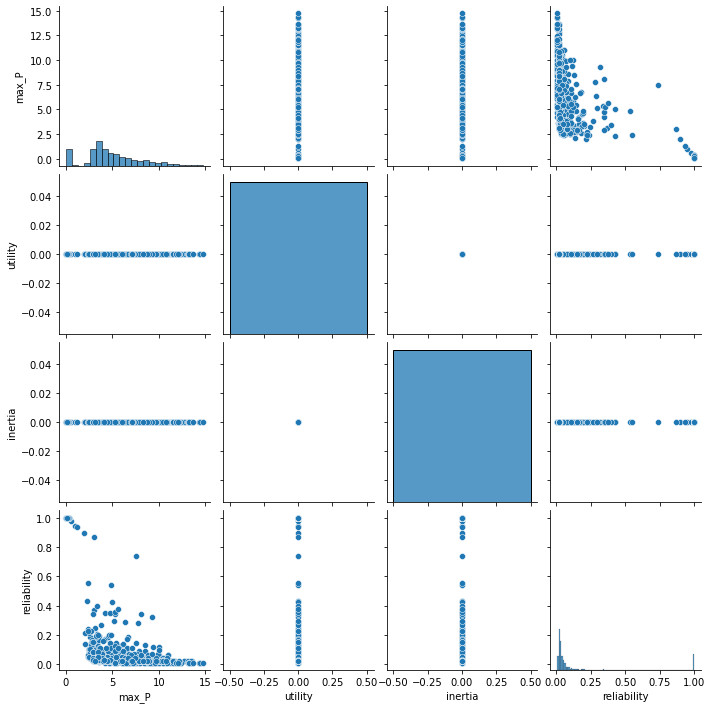

In [4]:
#visualise the outcomes of interest and trade-offs
sns.pairplot(process_data(experiments, outcomes), vars=outcomes.keys(), palette="pastel")
plt.show()

<h3 style="color: #FF1493"> Analysis - trade-offs</h3>
<p style="color: #FF1493">
    In plotting each of the four outcomes against each other, it is apparent that the main trade-off exists between max_P and reliability. Therefore, higher maximum concentrations of phosphorous in the lake is correlated to lower reliability of the lake (represented as the fraction of years where the concentration in the lake is below the critical threshold for phosphorous pollution).
</p>

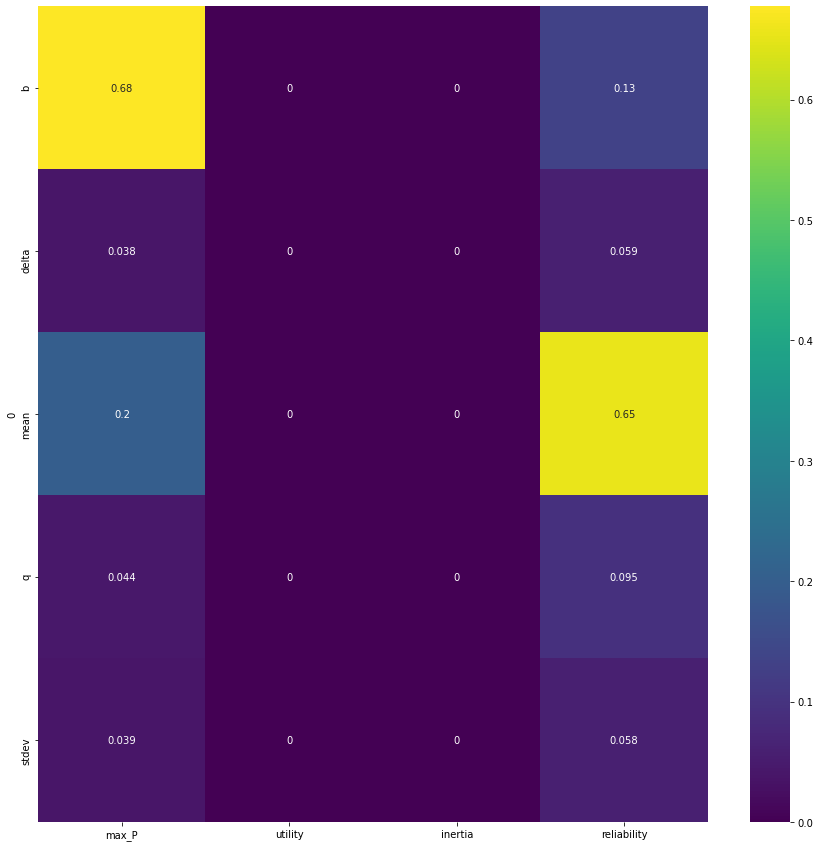

In [5]:
#visually identify the uncertainties that drive system behaviour
from ema_workbench.analysis import feature_scoring
 
x = experiments
y = outcomes
 
plt.figure(figsize=(15,15))
fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

<h3 style="color: #FF1493"> Analysis - uncertainties</h3>
<p style="color: #FF1493">
    A feature scoring assessment reveals that the uncertainty $b$ (the lake's natural removal rate) has the largest impact on the outcome for maximum phosphorous concentration. This is followed closely by the mean (mean of natural inflows into the lake) which influences the reliability of lake water quality. The other three uncertainties have less significant impact on the outcomes of interest. This suggests that these two features (which effectively represent natural inflows and outflows from the lake) are more likely to drive system behaviour than other quantified uncertainties.
</p>

3. Explore the behavior of the system over 1000 scenarios for 4 randomly sampled candidate strategies.
    * visualize the outcomes of interest
    * what can you say about how the release decision influences the system?

### Set levers

 Pearson correlation coefficient
                max_P  utility  inertia  reliability
max_P        1.000000      NaN      NaN    -0.598947
utility           NaN      NaN      NaN          NaN
inertia           NaN      NaN      NaN          NaN
reliability -0.598947      NaN      NaN     1.000000


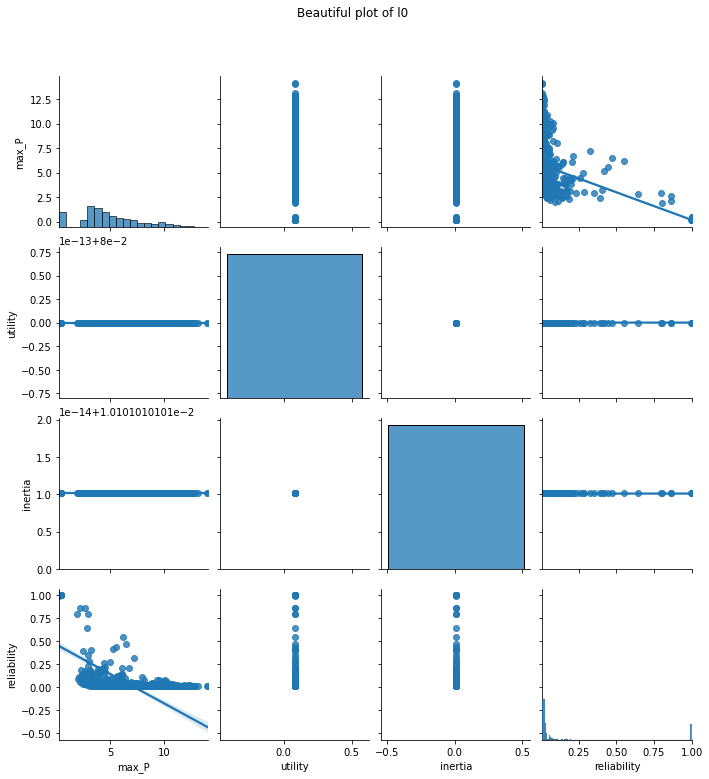

 Pearson correlation coefficient
                max_P   utility  inertia  reliability
max_P        1.000000 -0.005904      NaN    -0.543031
utility     -0.005904  1.000000      NaN     0.013554
inertia           NaN       NaN      NaN          NaN
reliability -0.543031  0.013554      NaN     1.000000


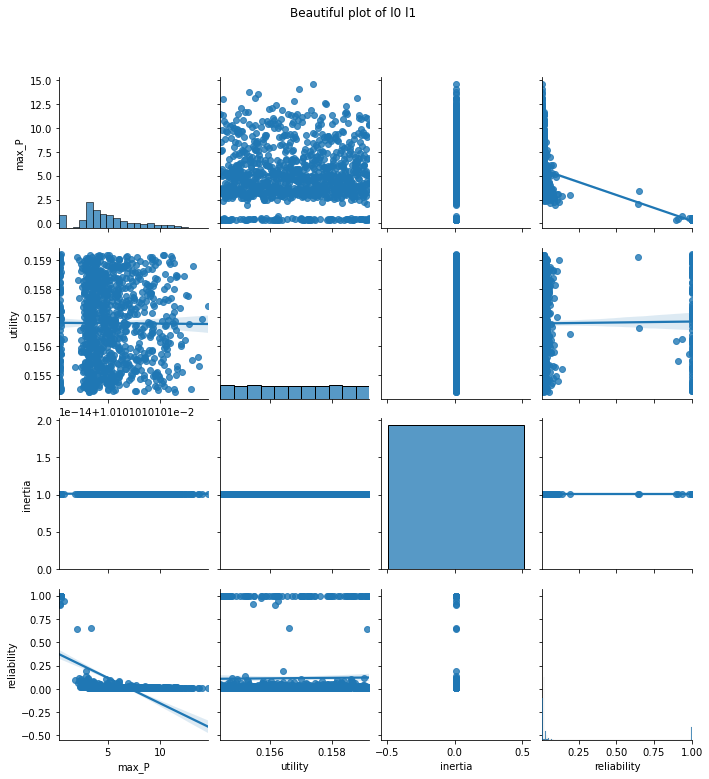

 Pearson correlation coefficient
                max_P   utility  inertia  reliability
max_P        1.000000  0.031819      NaN    -0.429235
utility      0.031819  1.000000      NaN    -0.023231
inertia           NaN       NaN      NaN          NaN
reliability -0.429235 -0.023231      NaN     1.000000


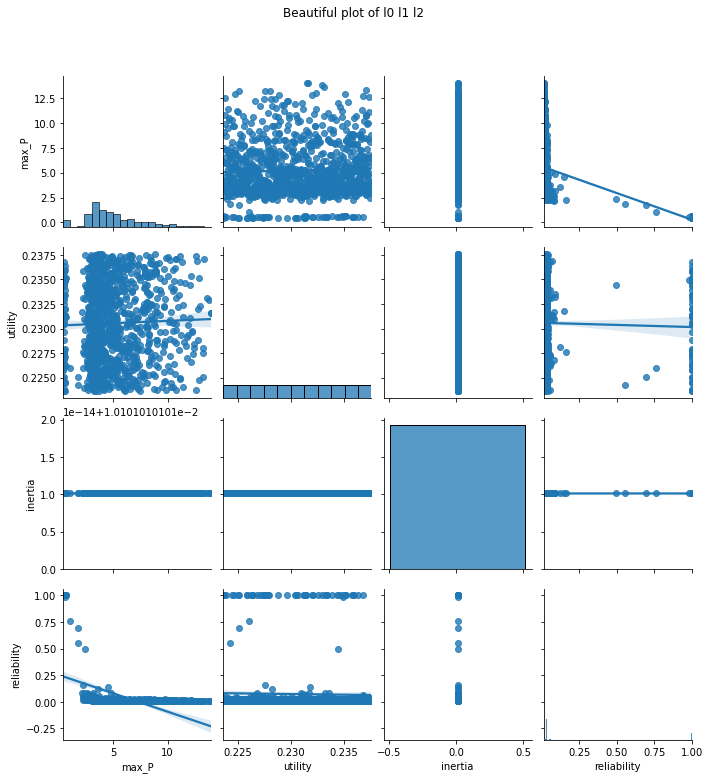

 Pearson correlation coefficient
                max_P   utility  inertia  reliability
max_P        1.000000 -0.019240      NaN    -0.300604
utility     -0.019240  1.000000      NaN     0.012548
inertia           NaN       NaN      NaN          NaN
reliability -0.300604  0.012548      NaN     1.000000


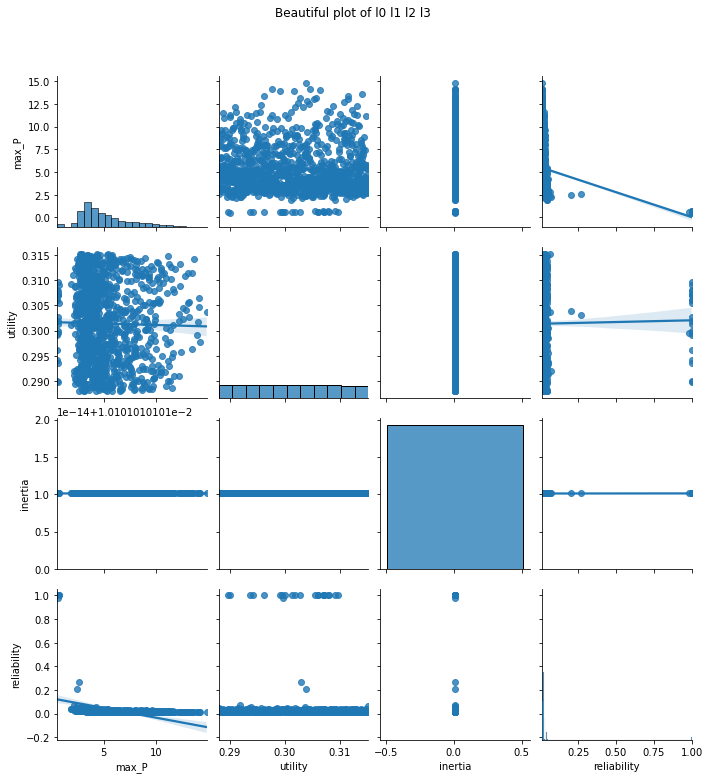

In [6]:
setmodel = Model('Lakemodel', function=lmf.lake_problem)

uncertainties = [RealParameter('mean', 0.01, 0.5),
                 RealParameter('stdev', 0.001, 0.005),
                 RealParameter('b', 0.1, 0.45),
                 RealParameter('q', 2, 4.5),
                 RealParameter('delta', 0.93, 0.99)]

outcomes = [ScalarOutcome('max_P', ScalarOutcome.MINIMIZE),
            ScalarOutcome('utility', ScalarOutcome.MAXIMIZE),
            ScalarOutcome('inertia', ScalarOutcome.INFO),
            ScalarOutcome('reliability', ScalarOutcome.MAXIMIZE)]

setmodel.uncertainties = uncertainties
setmodel.outcomes = outcomes

leversdict = {"l" + str(number): 0 for number in range(0,100)}
title= "Beautiful plot of "

for l in ["l0", "l1", "l2", "l3"]:
    leversdict[l] = 0.2
    setmodel.constants= [Constant(i[0], i[1]) for i in leversdict.items()]
    with SequentialEvaluator(setmodel) as evaluator:
        experiments, outcomes = evaluator.perform_experiments(scenarios=1000)
    
    data = process_data(experiments, outcomes)
    f= sns.pairplot(data, vars=outcomes.keys(), palette="Set1", kind="reg")
    
    print("\033[1m Pearson correlation coefficient\033[0m")
    print(data.corr(method="pearson"))
    title = title + l + " "
    f.fig.suptitle(title, y=1.08)
    plt.show()

<h3 style="color: #FF1493"> Analysis</h3>

<div style="color: #FF1493">
    In the above graphs, each subsequent graph shows the following lever being set to 0.2 instead of default 0. This means in first graph, l0 = 0.2 and l1-l99 = 0, in the second graph l0, l1 = 0.2, in the third graph l0, l1, l2 = 0.2, etc. 
    
<h4 style="color: #C71585" >Observations:</h4>
    
* In l0 inertia and utility are identical across all scenarios.
    
* For all graphs inertia and utility are invariant between one another. When one changes the other does not.
    
* A similar situation occurs for reliability and utility, however with outliers detected.
    
* Across scenarios utility and max_P show very little correlation (as shown by the Pearson correlation coefficient), meaning that high economic utility does not necessarily result in greater phosphorus contamination.
    
* Finally, for very low max_P level (close to 0), consistently results in high reliablity of 1. This suggest that ideally, phosphorus levels should be kept as low as possible.
    
* The pearson correlation coefficients also indicate there is correlation between the max_P level and the reliability, and that this correlation decreases as more levers are activated.
</div>

### Random levers

In [4]:
model.levers = [RealParameter("l" + str(number),0,0.1) for number in range(0,100)]

In [7]:
with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=4)

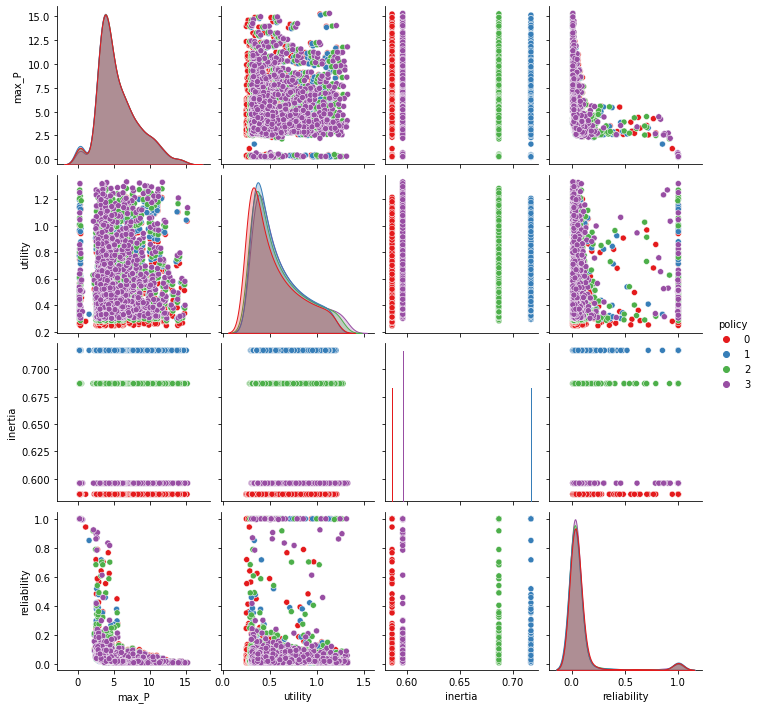

In [8]:
import warnings
warnings.filterwarnings('ignore')
sns.pairplot(process_data(experiments, outcomes), hue='policy', vars=outcomes.keys(), palette="Set1")
plt.show()

<h3 style="color: #FF1493"> Analysis - outcomes of interest</h3>
<p style="color: #FF1493">
    From this pairplot, there is one main trade-off of interest: between utility and max_P. The analysis shows that for policy 3, there is poorer outcomes in terms of utility even at lower levels of max_P, while policy 1 can achieve higher outcomes for utility at all ranges of max_P. This suggests that Policy 1 is a more robust policy for achieving better utility outcomes across a range of phosphorous pollution thresholds.
</p>

## Feature scoring

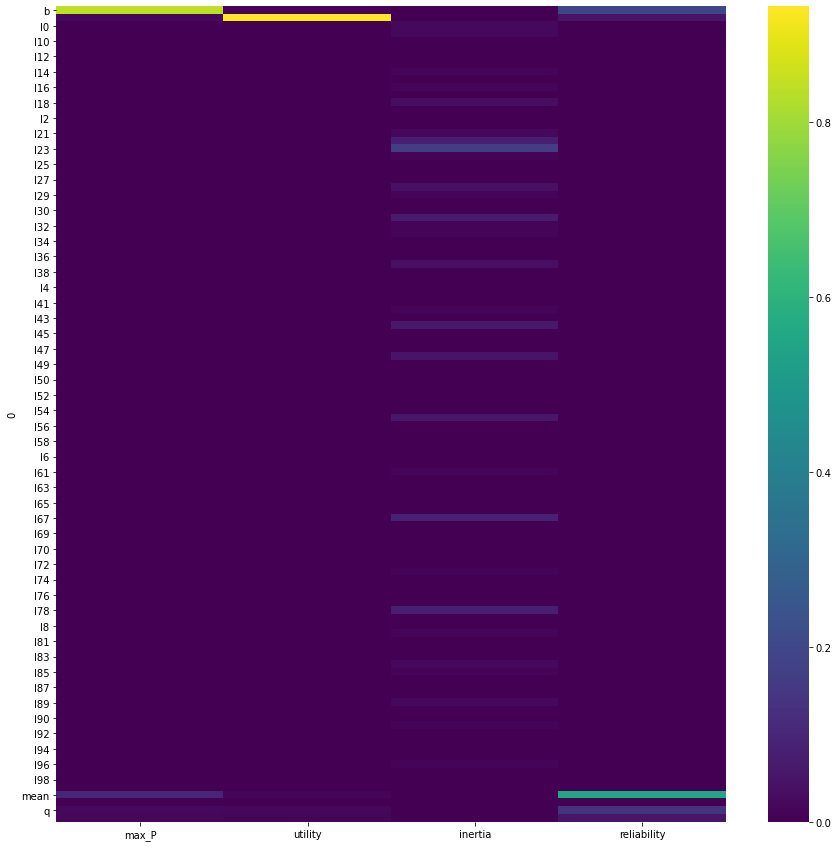

In [9]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes
    
plt.figure(figsize=(15,15))
fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=False)
plt.show()

<h3 style="color: #FF1493"> Analysis</h3>
<p style="color: #FF1493">
    From above feature scoring, we can see that the outcome of max_P is primarily influenced by b, whereas utility is influenced by l0. Reliability seems to be influenced by l98 and b.
</p>

4. If you have not used parallelization in the foregoing, try to adapt your code to use parallelization. The workbench comes with two evaluators for parallelization. The `MultiProcessingingEvaluator` and the `IpyparallelEvaluator`. When can you use each? Adapt your code from above and sue the `MultiProcessingingEvaluator`. Use the time library to check how much faster the computation for 1000 scenarios completes. 

Using multiprocessing within a jupyter notebook is tricky. On linux it will work in general just fine. On mac it depends on the version of Mac OS and the version of Python. If you are on the latest version of Mac OS in combination with Python 3.8, it might work but no guarantees. On older versions of Python it should work fine. On Windows it is always a problem. 

The underlying explanation is quite technical. It has to do with how your operating system creates the additional python processes. On windows, and the latest version of Mac OS in combination with Python 3.8. A completely new Python process is spawned. This new process does **not** inherit what is defined in memory of the parent process. The new child process will try to replicate what is in memory of the parent process by executing many of the import statements that have also been executed within the python process. Thus, if you define a model in the main process, it is not guaranteed to be known in the child processes. This is in particular true if you define the model within a jupyter notebook. Then the child processes will **never** know this function. Within jupyter notebooks, therefore, the best practice is to define your model within a .py file and import this .py file into the notebook. Now, each of the child processes will also execute this import statement and thus know the function. 


In [7]:
processes = 20

## MultiProcessingEvaluator

In [8]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model, processes) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=4)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


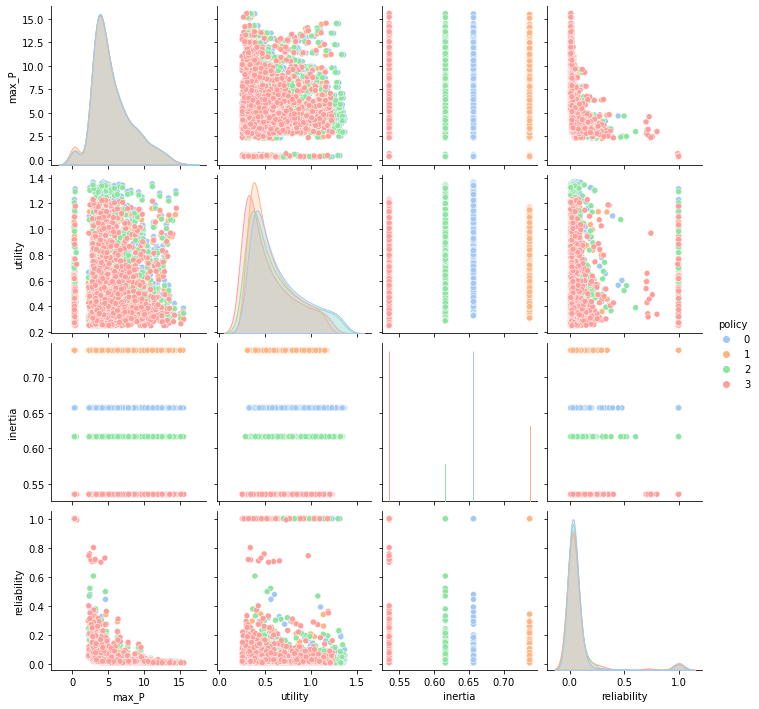

In [9]:
sns.pairplot(process_data(experiments, outcomes), hue='policy', vars=outcomes.keys(), palette="pastel")
plt.show()

## IpyparallelEvaluator

In [5]:
# for ipyparallel
# cd to this folder
# start cluster with ipcluster start -n ##
import ipyparallel
client = ipyparallel.Client()

In [6]:
client.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

[MainProcess/INFO] performing experiments using ipyparallel
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished
C:\Users\Lisette\anaconda3\envs\adsim\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Lisette\anaconda3\envs\adsim\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


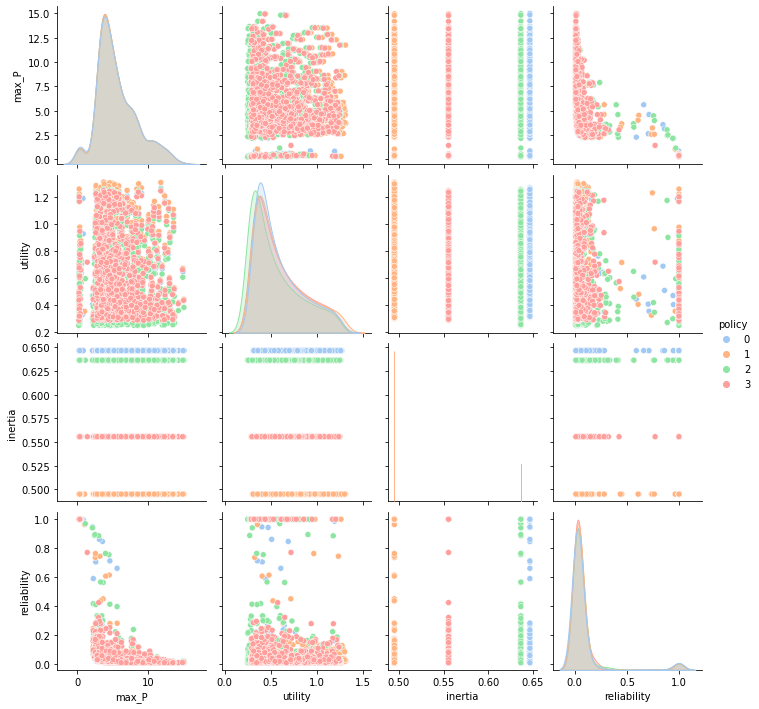

In [6]:
ema_logging.log_to_stderr(ema_logging.INFO)

with IpyparallelEvaluator(model, client) as evaluator:
    experiments, outcomes =  evaluator.perform_experiments(scenarios=1000, policies=4)
    
sns.pairplot(process_data(experiments, outcomes), hue='policy', vars=outcomes.keys(), palette="pastel")
plt.show()

### Timing

In [13]:
with SequentialEvaluator(model) as evaluator:
    %timeit experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=4)

[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases comp

2min 3s ± 350 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
processes = 20
with MultiprocessingEvaluator(model, processes) as evaluator:
    %timeit experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=4)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases co

9.09 s ± 27.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# for ipyparallel
# cd to this folder
# start cluster with ipcluster start -n ##
import ipyparallel
import time
client = ipyparallel.Client()
client.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [7]:
with IpyparallelEvaluator(model, client) as evaluator:
    start = time.time()
    experiments, outcomes =  evaluator.perform_experiments(scenarios=1000, policies=4)
    end = time.time()
print(end - start)

13.439337968826294


<h3 style="color: #FF1493"> Analysis - outcomes of interest</h3>
<p style="color: #FF1493">
    For the parallel evaluators we used 20 cores each. The different timeit results show that Multiprocessingevaluator is the fastest option for a model like this. It was expected that both, Ipyparallel and multiproccessing were quicker than the sequential evaulator. For further assignments Multiprocessingevaluator might thus be the better method. 
</p>